# Applied Data Science Capstone Project
### IBM Data Science Specialisation on Coursera

## Study of Rental Prices in Singapore
This study aims to provide an overview of rental prices in different parts of Singapore, and attempts to find a correlation between surround amenities with the prices. 

### Install Libraries: 

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
import json

from bs4 import BeautifulSoup 

from geopy.geocoders import Nominatim 
import geocoder

from pandas.io.json import json_normalize

import folium

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

### Data Preparation: 

#### 1. Information on Rental Prices from data.gov.sg
url: https://data.gov.sg/dataset/median-rent-by-town-and-flat-type


In [2]:
hdb_df = pd.read_csv('median-rent-by-town-and-flat-type.csv')
hdb_df.head()

quarter        town flat_type median_rent
0  2005-Q2  ANG MO KIO      1-RM          na
1  2005-Q2  ANG MO KIO      2-RM          na
2  2005-Q2  ANG MO KIO      3-RM         800
3  2005-Q2  ANG MO KIO      4-RM         950
4  2005-Q2  ANG MO KIO      5-RM           -

In [3]:
hdb_df.shape

(8781, 4)

In [4]:
hdb_df['flat_type'].unique()

array(['1-RM', '2-RM', '3-RM', '4-RM', '5-RM', 'EXEC'], dtype=object)

We're only interested in the more recent prices so let's drop the old data. 

In [5]:
df2019 = hdb_df[hdb_df['quarter'].str.contains('2019')].reset_index()
df2019.head(10)

index  quarter        town flat_type median_rent
0   8625  2019-Q1  ANG MO KIO      1-RM          na
1   8626  2019-Q1  ANG MO KIO      2-RM           -
2   8627  2019-Q1  ANG MO KIO      3-RM        1700
3   8628  2019-Q1  ANG MO KIO      4-RM        2100
4   8629  2019-Q1  ANG MO KIO      5-RM        2300
5   8630  2019-Q1  ANG MO KIO      EXEC           -
6   8631  2019-Q1       BEDOK      1-RM          na
7   8632  2019-Q1       BEDOK      2-RM           -
8   8633  2019-Q1       BEDOK      3-RM        1700
9   8634  2019-Q1       BEDOK      4-RM        2000

As 1-rm, 2-rm and executive suites are seldom available for rent, let's drop the data on those too. 

In [6]:
df_relevant = df2019[df2019['flat_type'].isin(['3-RM','4-RM','5-RM'])]
df_relevant.head()

index  quarter        town flat_type median_rent
2   8627  2019-Q1  ANG MO KIO      3-RM        1700
3   8628  2019-Q1  ANG MO KIO      4-RM        2100
4   8629  2019-Q1  ANG MO KIO      5-RM        2300
8   8633  2019-Q1       BEDOK      3-RM        1700
9   8634  2019-Q1       BEDOK      4-RM        2000

In [7]:
df_relevant.drop(['index'],axis =1,inplace = True)
df_relevant.head()

D:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


quarter        town flat_type median_rent
2  2019-Q1  ANG MO KIO      3-RM        1700
3  2019-Q1  ANG MO KIO      4-RM        2100
4  2019-Q1  ANG MO KIO      5-RM        2300
8  2019-Q1       BEDOK      3-RM        1700
9  2019-Q1       BEDOK      4-RM        2000

Let's transpose the data such that the rent of each type of flat is shown in a column. 

In [8]:
df_pivot = df_relevant.pivot(index='town', columns='flat_type', values='median_rent')
df_pivot.head()

flat_type    3-RM  4-RM  5-RM
town                         
ANG MO KIO   1700  2100  2300
BEDOK        1700  2000  2250
BISHAN       1800  2200  2500
BUKIT BATOK  1600  1900  2100
BUKIT MERAH  1900  2500  2800

In [9]:
df_final = df_pivot.reset_index()
df_final.head()

flat_type         town  3-RM  4-RM  5-RM
0           ANG MO KIO  1700  2100  2300
1                BEDOK  1700  2000  2250
2               BISHAN  1800  2200  2500
3          BUKIT BATOK  1600  1900  2100
4          BUKIT MERAH  1900  2500  2800

In [10]:
df_final.shape

(26, 4)

In [13]:
df_final.replace(to_replace='-', value=np.NaN, inplace=True)
df_final

flat_type             town  3-RM  4-RM  5-RM
0               ANG MO KIO  1700  2100  2300
1                    BEDOK  1700  2000  2250
2                   BISHAN  1800  2200  2500
3              BUKIT BATOK  1600  1900  2100
4              BUKIT MERAH  1900  2500  2800
5            BUKIT PANJANG  1500  1700  1900
6              BUKIT TIMAH   NaN   NaN   NaN
7                  CENTRAL  2150  2700   NaN
8            CHOA CHU KANG   NaN  1700  1800
9                 CLEMENTI  1800  2300  2580
10                 GEYLANG  1800  2300  2500
11                 HOUGANG  1600  1900  2050
12             JURONG EAST  1700  2030  2300
13             JURONG WEST  1600  1950  2100
14         KALLANG/WHAMPOA  1850  2400  2600
15           MARINE PARADE  1850  2100  2500
16               PASIR RIS   NaN  2000  2100
17                 PUNGGOL   NaN  1800  1900
18              QUEENSTOWN  1900  2500  2800
19               SEMBAWANG   NaN  1800  1900
20                SENGKANG   NaN  1850  1900
21               SERANGOON  1800  2200  2250
22                TAMPINES  1700  2000  2200
23               TOA PAYOH  1800  2250  2500
24               WOODLANDS  1400  1750  1800
25                  YISHUN  1550  1800  2000

In [14]:
df_final[['3-RM','4-RM','5-RM']] = df_final[['3-RM','4-RM','5-RM']].apply(pd.to_numeric)
df_final

flat_type             town    3-RM    4-RM    5-RM
0               ANG MO KIO  1700.0  2100.0  2300.0
1                    BEDOK  1700.0  2000.0  2250.0
2                   BISHAN  1800.0  2200.0  2500.0
3              BUKIT BATOK  1600.0  1900.0  2100.0
4              BUKIT MERAH  1900.0  2500.0  2800.0
5            BUKIT PANJANG  1500.0  1700.0  1900.0
6              BUKIT TIMAH     NaN     NaN     NaN
7                  CENTRAL  2150.0  2700.0     NaN
8            CHOA CHU KANG     NaN  1700.0  1800.0
9                 CLEMENTI  1800.0  2300.0  2580.0
10                 GEYLANG  1800.0  2300.0  2500.0
11                 HOUGANG  1600.0  1900.0  2050.0
12             JURONG EAST  1700.0  2030.0  2300.0
13             JURONG WEST  1600.0  1950.0  2100.0
14         KALLANG/WHAMPOA  1850.0  2400.0  2600.0
15           MARINE PARADE  1850.0  2100.0  2500.0
16               PASIR RIS     NaN  2000.0  2100.0
17                 PUNGGOL     NaN  1800.0  1900.0
18              QUEENSTOWN  1900.0  2500.0  2800.0
19               SEMBAWANG     NaN  1800.0  1900.0
20                SENGKANG     NaN  1850.0  1900.0
21               SERANGOON  1800.0  2200.0  2250.0
22                TAMPINES  1700.0  2000.0  2200.0
23               TOA PAYOH  1800.0  2250.0  2500.0
24               WOODLANDS  1400.0  1750.0  1800.0
25                  YISHUN  1550.0  1800.0  2000.0

In [15]:
type(df_final['3-RM'][10])

numpy.float64

In [16]:
df_final['avg_price'] = df_final.iloc[:, 1:5].mean(axis=1,skipna=True)

In [17]:
df_final['avg_price'] = df_final['avg_price'].round(2)

In [18]:
df_final

flat_type             town    3-RM    4-RM    5-RM  avg_price
0               ANG MO KIO  1700.0  2100.0  2300.0    2033.33
1                    BEDOK  1700.0  2000.0  2250.0    1983.33
2                   BISHAN  1800.0  2200.0  2500.0    2166.67
3              BUKIT BATOK  1600.0  1900.0  2100.0    1866.67
4              BUKIT MERAH  1900.0  2500.0  2800.0    2400.00
5            BUKIT PANJANG  1500.0  1700.0  1900.0    1700.00
6              BUKIT TIMAH     NaN     NaN     NaN        NaN
7                  CENTRAL  2150.0  2700.0     NaN    2425.00
8            CHOA CHU KANG     NaN  1700.0  1800.0    1750.00
9                 CLEMENTI  1800.0  2300.0  2580.0    2226.67
10                 GEYLANG  1800.0  2300.0  2500.0    2200.00
11                 HOUGANG  1600.0  1900.0  2050.0    1850.00
12             JURONG EAST  1700.0  2030.0  2300.0    2010.00
13             JURONG WEST  1600.0  1950.0  2100.0    1883.33
14         KALLANG/WHAMPOA  1850.0  2400.0  2600.0    2283.33
15           MARINE PARADE  1850.0  2100.0  2500.0    2150.00
16               PASIR RIS     NaN  2000.0  2100.0    2050.00
17                 PUNGGOL     NaN  1800.0  1900.0    1850.00
18              QUEENSTOWN  1900.0  2500.0  2800.0    2400.00
19               SEMBAWANG     NaN  1800.0  1900.0    1850.00
20                SENGKANG     NaN  1850.0  1900.0    1875.00
21               SERANGOON  1800.0  2200.0  2250.0    2083.33
22                TAMPINES  1700.0  2000.0  2200.0    1966.67
23               TOA PAYOH  1800.0  2250.0  2500.0    2183.33
24               WOODLANDS  1400.0  1750.0  1800.0    1650.00
25                  YISHUN  1550.0  1800.0  2000.0    1783.33

### Get town coordinates

In [19]:
def get_lat_lng(town):
    lat_lng_coords = None
    while lat_lng_coords is None: 
        g = geocoder.arcgis('{}, Singapore, Singapore'.format(town))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [20]:
coords = [get_lat_lng(town) for town in df_final['town'].tolist()]

In [21]:
df_coords = pd.DataFrame(coords, columns=['latitude','longitude'])
df_final['latitude'] = df_coords['latitude']
df_final['longitude'] = df_coords['longitude']
df_final

flat_type             town    3-RM    4-RM    5-RM  avg_price  latitude  \
0               ANG MO KIO  1700.0  2100.0  2300.0    2033.33  1.371610   
1                    BEDOK  1700.0  2000.0  2250.0    1983.33  1.324260   
2                   BISHAN  1800.0  2200.0  2500.0    2166.67  1.350790   
3              BUKIT BATOK  1600.0  1900.0  2100.0    1866.67  1.349520   
4              BUKIT MERAH  1900.0  2500.0  2800.0    2400.00  1.283220   
5            BUKIT PANJANG  1500.0  1700.0  1900.0    1700.00  1.378770   
6              BUKIT TIMAH     NaN     NaN     NaN        NaN  1.340410   
7                  CENTRAL  2150.0  2700.0     NaN    2425.00  1.298680   
8            CHOA CHU KANG     NaN  1700.0  1800.0    1750.00  1.386160   
9                 CLEMENTI  1800.0  2300.0  2580.0    2226.67  1.314380   
10                 GEYLANG  1800.0  2300.0  2500.0    2200.00  1.311470   
11                 HOUGANG  1600.0  1900.0  2050.0    1850.00  1.371140   
12             JURONG EAST  1700.0  2030.0  2300.0    2010.00  1.334370   
13             JURONG WEST  1600.0  1950.0  2100.0    1883.33  1.339490   
14         KALLANG/WHAMPOA  1850.0  2400.0  2600.0    2283.33  1.323286   
15           MARINE PARADE  1850.0  2100.0  2500.0    2150.00  1.321480   
16               PASIR RIS     NaN  2000.0  2100.0    2050.00  1.371940   
17                 PUNGGOL     NaN  1800.0  1900.0    1850.00  1.402460   
18              QUEENSTOWN  1900.0  2500.0  2800.0    2400.00  1.299660   
19               SEMBAWANG     NaN  1800.0  1900.0    1850.00  1.447940   
20                SENGKANG     NaN  1850.0  1900.0    1875.00  1.392460   
21               SERANGOON  1800.0  2200.0  2250.0    2083.33  1.355540   
22                TAMPINES  1700.0  2000.0  2200.0    1966.67  1.368190   
23               TOA PAYOH  1800.0  2250.0  2500.0    2183.33  1.334480   
24               WOODLANDS  1400.0  1750.0  1800.0    1650.00  1.435850   
25                  YISHUN  1550.0  1800.0  2000.0    1783.33  1.436210   

flat_type   longitude  
0          103.845460  
1          103.952960  
2          103.851100  
3          103.752770  
4          103.816760  
5          103.769770  
6          103.772210  
7          103.853670  
8          103.746180  
9          103.765370  
10         103.882180  
11         103.891440  
12         103.743670  
13         103.707390  
14         103.856267  
15         103.870480  
16         103.949940  
17         103.906860  
18         103.801720  
19         103.818910  
20         103.894590  
21         103.876600  
22         103.929480  
23         103.851080  
24         103.786980  
25         103.835820

### Create map of Singapore

In [22]:
address = 'Singapore, Singapore'

geolocator = Nominatim(user_agent='sg_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geographical coordinates of Singapore is {},{}.'.format(latitude,longitude))

The geographical coordinates of Singapore is 1.3408528,103.878446863736.


In [24]:
sg_map = folium.Map(location = [latitude,longitude], zoom_start = 12)

for lat, lng, town, price in zip(df_final['latitude'],df_final['longitude'],df_final['town'], df_final['avg_price']):
    label = '{}, {}'.format(town,price)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat,lng],
        radius = 4,
        popup = label,
        color = 'crimson',
        fill = True,
        fill_color = 'yellow',
        fill_opacity = 0.7).add_to(sg_map)

sg_map

Now we have a map which marks out all the residential areas in Singapore. But that doesn't tell us much doesn't it? Let's do a choropleth map that shows the different rental prices by area.

In [25]:
sg_geo_data = r'2-planning-area.geojson'

In [26]:
sg_map2 = folium.Map(location = [latitude,longitude], zoom_start =12)

sg_map2.choropleth(
    geo_data = sg_geo_data,
    data = df_final,
    columns = ['town','avg_price'],
    key_on = 'feature.properties.name',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Average monthly rental prices in Singapore')

for lat, lng, town, price in zip(df_final['latitude'],df_final['longitude'],df_final['town'], df_final['avg_price']):
    label = '{}, {}'.format(town,price)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat,lng],
        radius = 4,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = 'lime',
        fill_opacity = 0.7).add_to(sg_map2)

sg_map2

D:\Program Files (x86)\Anaconda\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


We can see that the central downtown area has the highest average rental prices, while prices are lowest in the north and west. The black out parts do not have any housing information - they are either non-residential areas, or the houses there are mostly not for rental. Eg. Bukit Timah, well-known area for landed properties, will not have many flats for rental.  

### Use FourSquare to get surrounding venues

In [27]:
CLIENT_ID = '0VPJOAXTMQMNJYVFXT4OYUNLOXHUNNN33ZDUJ4TCV3LXMXIX'
CLIENT_SECRET = 'E00HLG2BTOYCA3DYTH3JC2H1MSM4LBCVYV25ZLJPNQIZKLA3&v=20190830'
VERSION = '20190901'

In [28]:
radius = 2000
LIMIT = 100

venues = [] 

for lat, long, town in zip(df_final['latitude'], df_final['longitude'], df_final['town']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius,
        LIMIT)
    results = requests.get(url).json()['response']['groups'][0]['items']
    
    for venue in results:
        venues.append((
            town,
            lat,
            long,
            venue['venue']['name'],
            venue['venue']['location']['lat'],
            venue['venue']['location']['lng'],
            venue['venue']['categories'][0]['name']))

In [29]:
df_venues = pd.DataFrame(venues)

df_venues.columns = ['Town', 'Latitude', 'Longitude', 'VenueName', 'VenueLat', 'VenueLong', 'Category']
df_venues.head()

Town  Latitude  Longitude                       VenueName  VenueLat  \
0  ANG MO KIO   1.37161  103.84546        Bishan - Ang Mo Kio Park  1.362219   
1  ANG MO KIO   1.37161  103.84546                   Old Chang Kee  1.369094   
2  ANG MO KIO   1.37161  103.84546         Aramsa ~ The Garden Spa  1.362292   
3  ANG MO KIO   1.37161  103.84546  Face Ban Mian 非板面 (Ang Mo Kio)  1.372031   
4  ANG MO KIO   1.37161  103.84546       Kam Jia Zhuang Restaurant  1.368167   

    VenueLong          Category  
0  103.846250              Park  
1  103.848389       Snack Place  
2  103.847602               Spa  
3  103.847504      Noodle House  
4  103.844118  Asian Restaurant

In [30]:
df_venues.groupby(['Town']).count()

Latitude  Longitude  VenueName  VenueLat  VenueLong  Category
Town                                                                          
ANG MO KIO            100        100        100       100        100       100
BEDOK                 100        100        100       100        100       100
BISHAN                100        100        100       100        100       100
BUKIT BATOK            96         96         96        96         96        96
BUKIT MERAH           100        100        100       100        100       100
BUKIT PANJANG          74         74         74        74         74        74
BUKIT TIMAH           100        100        100       100        100       100
CENTRAL               100        100        100       100        100       100
CHOA CHU KANG          76         76         76        76         76        76
CLEMENTI              100        100        100       100        100       100
GEYLANG               100        100        100       100        100       100
HOUGANG               100        100        100       100        100       100
JURONG EAST           100        100        100       100        100       100
JURONG WEST            96         96         96        96         96        96
KALLANG/WHAMPOA       100        100        100       100        100       100
MARINE PARADE         100        100        100       100        100       100
PASIR RIS              97         97         97        97         97        97
PUNGGOL                96         96         96        96         96        96
QUEENSTOWN            100        100        100       100        100       100
SEMBAWANG              60         60         60        60         60        60
SENGKANG              100        100        100       100        100       100
SERANGOON             100        100        100       100        100       100
TAMPINES               39         39         39        39         39        39
TOA PAYOH             100        100        100       100        100       100
WOODLANDS              86         86         86        86         86        86
YISHUN                 91         91         91        91         91        91

In [31]:
df_venues['Category'].unique()


array(['Park', 'Snack Place', 'Spa', 'Noodle House', 'Asian Restaurant',
       'Supermarket', 'Sandwich Place', 'Chinese Restaurant', 'Bakery',
       'Seafood Restaurant', 'Burger Joint', 'Halal Restaurant',
       'Coffee Shop', 'College Cafeteria', 'BBQ Joint', 'Ice Cream Shop',
       'Hobby Shop', 'Dog Run', 'Gym', 'Japanese Restaurant',
       'Food Court', 'Bar', 'Bank', 'Dessert Shop', 'Restaurant',
       'Modern European Restaurant', 'Shanghai Restaurant', 'Soup Place',
       'Bubble Tea Shop', 'Miscellaneous Shop', 'Pool Hall', 'Pool',
       'Thai Restaurant', 'Café', 'Indian Restaurant',
       'Vegetarian / Vegan Restaurant', 'Office', 'Cosmetics Shop',
       'Stadium', 'Fast Food Restaurant', 'Australian Restaurant',
       'Market', 'Grocery Store', 'Zhejiang Restaurant', 'Golf Course',
       'Hotel', 'Beach', 'Sporting Goods Shop', 'Filipino Restaurant',
       'Electronics Store', 'Malay Restaurant', 'Discount Store',
       'Harbor / Marina', 'Hardware Store', 'S

Let's show these venues on the map:

In [76]:
sg_map3 = folium.Map(location = [latitude,longitude], zoom_start =12)

sg_map3.choropleth(
    geo_data = sg_geo_data,
    data = df_final,
    columns = ['town','avg_price'],
    key_on = 'feature.properties.name',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Average monthly rental prices in Singapore')

for lat, lng, town, price in zip(df_final['latitude'],df_final['longitude'],df_final['town'], df_final['avg_price']):
    label = '{}, {}'.format(town,price)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat,lng],
        radius = 4,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = 'lime',
        fill_opacity = 0.7).add_to(sg_map3)
    
for lat, lng, town, venue in zip(df_venues['VenueLat'],df_venues['VenueLong'],df_venues['Town'], df_venues['VenueName']):
    label = '{}, {}'.format(town,venue)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat,lng],
        radius = 2,
        popup = label,
        color = 'lime',
        fill = True,
        fill_color = 'yellow',
        fill_opacity = 0.7).add_to(sg_map3)

sg_map3

We cannot really observe any patterns from the map above, except that these venues of interest crowd more around the respective town centres. But we do not observe any differences like the most expensive rental prices having more amenities. We would need to do a deeper analysis of the venues to gain further insight. 

In [32]:
#one hot encoding
venues_category_onehot = pd.get_dummies(df_venues[['Category']], prefix='', prefix_sep='')

venues_category_onehot['Town'] = df_venues['Town']
columns = list(venues_category_onehot.columns[-1:]) + list(venues_category_onehot.columns[:-1])
venues_category_onehot = venues_category_onehot[columns]

venues_category_onehot.head()

Town  Accessories Store  American Restaurant  Art Gallery  \
0  ANG MO KIO                  0                    0            0   
1  ANG MO KIO                  0                    0            0   
2  ANG MO KIO                  0                    0            0   
3  ANG MO KIO                  0                    0            0   
4  ANG MO KIO                  0                    0            0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0                    0                 0                   0   
1                    0                 0                   0   
2                    0                 0                   0   
3                    0                 0                   0   
4                    0                 1                   0   

   Australian Restaurant  Auto Garage  BBQ Joint  Bagel Shop  Bakery  Bank  \
0                      0            0          0           0       0     0   
1                      0            0          0           0       0     0   
2                      0            0          0           0       0     0   
3                      0            0          0           0       0     0   
4                      0            0          0           0       0     0   

   Bar  Basketball Court  Beach  Beach Bar  Beer Bar  Beer Garden  Beer Store  \
0    0                 0      0          0         0            0           0   
1    0                 0      0          0         0            0           0   
2    0                 0      0          0         0            0           0   
3    0                 0      0          0         0            0           0   
4    0                 0      0          0         0            0           0   

   Betting Shop  Big Box Store  Bike Trail  Bistro  Boarding House  \
0             0              0           0       0               0   
1             0              0           0       0               0   
2             0              0           0       0               0   
3             0              0           0       0               0   
4             0              0           0       0               0   

   Boat or Ferry  Bookstore  Boutique  Bowling Alley  Bowling Green  \
0              0          0         0              0              0   
1              0          0         0              0              0   
2              0          0         0              0              0   
3              0          0         0              0              0   
4              0          0         0              0              0   

   Breakfast Spot  Bridge  Bubble Tea Shop  Buffet  Building  Burger Joint  \
0               0       0                0       0         0             0   
1               0       0                0       0         0             0   
2               0       0                0       0         0             0   
3               0       0                0       0         0             0   
4               0       0                0       0         0             0   

   Burrito Place  Bus Line  Bus Station  Bus Stop  Butcher  Cafeteria  Café  \
0              0         0            0         0        0          0     0   
1              0         0            0         0        0          0     0   
2              0         0            0         0        0          0     0   
3              0         0            0         0        0          0     0   
4              0         0            0         0        0          0     0   

   Cantonese Restaurant  Cha Chaan Teng  Chinese Breakfast Place  \
0                     0               0                        0   
1                     0               0                        0   
2                     0               0                        0   
3                     0               0                        0   
4                     0               0                        0   

   Chinese Restaurant  Climbing Gym  Clothing 

In [33]:
df_venue_count = venues_category_onehot.groupby(['Town']).sum().reset_index()

df_venue_count.head()

Town  Accessories Store  American Restaurant  Art Gallery  \
0   ANG MO KIO                  0                    0            0   
1        BEDOK                  0                    0            0   
2       BISHAN                  0                    0            0   
3  BUKIT BATOK                  1                    1            0   
4  BUKIT MERAH                  0                    0            1   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0                    0                 3                   0   
1                    0                 3                   0   
2                    0                 4                   0   
3                    0                 0                   0   
4                    0                 1                   0   

   Australian Restaurant  Auto Garage  BBQ Joint  Bagel Shop  Bakery  Bank  \
0                      1            0          2           0       2     1   
1                      0            0          2           0       1     0   
2                      0            0          3           0       3     0   
3                      1            1          1           0       0     0   
4                      0            0          0           0       4     0   

   Bar  Basketball Court  Beach  Beach Bar  Beer Bar  Beer Garden  Beer Store  \
0    2                 0      0          0         0            0           0   
1    1                 0      2          0         0            0           0   
2    1                 0      0          0         0            0           0   
3    1                 0      0          0         1            1           0   
4    1                 0      0          0         0            0           0   

   Betting Shop  Big Box Store  Bike Trail  Bistro  Boarding House  \
0             0              0           0       0               0   
1             0              0           0       0               0   
2             0              0           0       0               0   
3             0              0           0       0               0   
4             0              0           0       0               0   

   Boat or Ferry  Bookstore  Boutique  Bowling Alley  Bowling Green  \
0              0          0         0              0              0   
1              0          0         0              0              0   
2              0          1         0              0              0   
3              0          0         0              2              0   
4              0          2         0              0              0   

   Breakfast Spot  Bridge  Bubble Tea Shop  Buffet  Building  Burger Joint  \
0               0       0                1       0         0             1   
1               1       0                0       0         0             1   
2               0       0                1       0         0             0   
3               0       0                0       0         0             0   
4               0       1                0       0         0             0   

   Burrito Place  Bus Line  Bus Station  Bus Stop  Butcher  Cafeteria  Café  \
0              0         0            0         0        0          0     4   
1              0         0            0         0        0          0     8   
2              0         0            0         0        0          0     4   
3              0         0            2         0        0          1     3   
4              0         0            0         0        0          0     8   

   Cantonese Restaurant  Cha Chaan Teng  Chinese Breakfast Place  \
0                     0               0                        0   
1                     0               0                        0   
2                     0               0                        0   
3                     1               0                        0   
4                     0               0                        0   

   Chinese Restaurant  Climbing Gym  Clot

In [34]:
from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

In [35]:
scaler = StandardScaler()
standardised_price = scaler.fit_transform(df_final[['avg_price']])

df_town_venues = pd.DataFrame(df_venue_count)
df_town_venues['standardised_avg_price'] = standardised_price

df_town_venues.head()

Town  Accessories Store  American Restaurant  Art Gallery  \
0   ANG MO KIO                  0                    0            0   
1        BEDOK                  0                    0            0   
2       BISHAN                  0                    0            0   
3  BUKIT BATOK                  1                    1            0   
4  BUKIT MERAH                  0                    0            1   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0                    0                 3                   0   
1                    0                 3                   0   
2                    0                 4                   0   
3                    0                 0                   0   
4                    0                 1                   0   

   Australian Restaurant  Auto Garage  BBQ Joint  Bagel Shop  Bakery  Bank  \
0                      1            0          2           0       2     1   
1                      0            0          2           0       1     0   
2                      0            0          3           0       3     0   
3                      1            1          1           0       0     0   
4                      0            0          0           0       4     0   

   Bar  Basketball Court  Beach  Beach Bar  Beer Bar  Beer Garden  Beer Store  \
0    2                 0      0          0         0            0           0   
1    1                 0      2          0         0            0           0   
2    1                 0      0          0         0            0           0   
3    1                 0      0          0         1            1           0   
4    1                 0      0          0         0            0           0   

   Betting Shop  Big Box Store  Bike Trail  Bistro  Boarding House  \
0             0              0           0       0               0   
1             0              0           0       0               0   
2             0              0           0       0               0   
3             0              0           0       0               0   
4             0              0           0       0               0   

   Boat or Ferry  Bookstore  Boutique  Bowling Alley  Bowling Green  \
0              0          0         0              0              0   
1              0          0         0              0              0   
2              0          1         0              0              0   
3              0          0         0              2              0   
4              0          2         0              0              0   

   Breakfast Spot  Bridge  Bubble Tea Shop  Buffet  Building  Burger Joint  \
0               0       0                1       0         0             1   
1               1       0                0       0         0             1   
2               0       0                1       0         0             0   
3               0       0                0       0         0             0   
4               0       1                0       0         0             0   

   Burrito Place  Bus Line  Bus Station  Bus Stop  Butcher  Cafeteria  Café  \
0              0         0            0         0        0          0     4   
1              0         0            0         0        0          0     8   
2              0         0            0         0        0          0     4   
3              0         0            2         0        0          1     3   
4              0         0            0         0        0          0     8   

   Cantonese Restaurant  Cha Chaan Teng  Chinese Breakfast Place  \
0                     0               0                        0   
1                     0               0                        0   
2                     0               0                        0   
3                     1               0                        0   
4                     0               0                        0   

   Chinese Restaurant  Climbing Gym  Clot

In [36]:
df_town_venues.isnull()

df_town_venues.dropna(axis = 0, inplace = True)

df_town_venues

Town  Accessories Store  American Restaurant  Art Gallery  \
0        ANG MO KIO                  0                    0            0   
1             BEDOK                  0                    0            0   
2            BISHAN                  0                    0            0   
3       BUKIT BATOK                  1                    1            0   
4       BUKIT MERAH                  0                    0            1   
5     BUKIT PANJANG                  0                    1            0   
7           CENTRAL                  0                    0            3   
8     CHOA CHU KANG                  0                    0            0   
9          CLEMENTI                  0                    0            1   
10          GEYLANG                  0                    0            0   
11          HOUGANG                  0                    0            0   
12      JURONG EAST                  1                    1            0   
13      JURONG WEST                  0                    1            0   
14  KALLANG/WHAMPOA                  0                    0            0   
15    MARINE PARADE                  0                    0            0   
16        PASIR RIS                  0                    1            0   
17          PUNGGOL                  0                    0            0   
18       QUEENSTOWN                  0                    0            0   
19        SEMBAWANG                  0                    1            0   
20         SENGKANG                  0                    0            0   
21        SERANGOON                  0                    0            0   
22         TAMPINES                  0                    0            0   
23        TOA PAYOH                  0                    0            0   
24        WOODLANDS                  0                    0            0   
25           YISHUN                  0                    2            0   

    Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0                     0                 3                   0   
1                     0                 3                   0   
2                     0                 4                   0   
3                     0                 0                   0   
4                     0                 1                   0   
5                     0                 3                   1   
7                     2                 0                   0   
8                     0                 4                   0   
9                     1                 3                   0   
10                    0                 4                   1   
11                    0                 5                   1   
12                    0                 1                   1   
13                    0                 5                   0   
14                    0                 2                   0   
15                    0                 5                   0   
16                    0                 3                   0   
17                    0                 2                   0   
18                    0                 3                   0   
19                    0                 6                   0   
20                    0                 2                   0   
21                    0                 4                   0   
22                    0                 2                   0   
23                    0                 3                   0   
24                    0                 3                   0   
25                    0                 8                   0   

    Australian Restaurant  Auto Garage  BBQ Joint  Bagel Shop  Bakery  Bank  \
0                       1            0          2           0       2     1   
1                       0            0          2           0       1     0   
2                       0            0          3           0       3     0   
3                       1      

### Check for correlation between type of surrounding venue with average rental price

In [37]:
lr = LinearRegression(normalize = True)

X = df_town_venues.drop(columns=['Town', 'standardised_avg_price'])
y = df_town_venues['standardised_avg_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 0)

model = lr.fit(X_train, y_train)

In [38]:
yhat = lr.predict(X_test)

In [39]:
r2_score(y_test, yhat)

0.4385441130503912

In [40]:
mean_squared_error(y_test, yhat)

0.2933348036832228

In [41]:
# Venue categories with the most positive effect
X.columns[np.argsort(-lr.coef_)[:10]].values

array(['Pakistani Restaurant', 'Mountain', 'Organic Grocery',
       'Cupcake Shop', 'Bridge', 'Garden', 'Chinese Breakfast Place',
       'Video Game Store', 'Hot Dog Joint', 'Motorcycle Shop'],
      dtype=object)

In [42]:
# Venue categories with the most negative effect
X.columns[np.argsort(lr.coef_)[:10]].values

array(['College Theater', 'Smoke Shop', 'Post Office', 'College Gym',
       'Portuguese Restaurant', 'Diner', 'Light Rail Station',
       'Food & Drink Shop', 'Electronics Store', 'Club House'],
      dtype=object)

In [43]:
# Venue categories with the least effect

X.columns[np.argsort(abs(lr.coef_))[:10]].values

array(['Zoo Exhibit', 'Parking', 'Rest Area', 'Hockey Arena',
       'Science Museum', 'Sculpture Garden', 'Donut Shop', 'Ski Area',
       'Nature Preserve', 'Military Base'], dtype=object)

**Comments:** 
The model doesn't seem right for the dataset as the R2 score is small, and the results regarding the venue types that has the most impact doesn't really make sense. It's unlikely for a Pakistani restaurant to have a super big positive effect on rental price, and it's unlikely that a post office will have a negative effect on the rental price as well. 

Since a linear model doesn't fit, we will try principal component analysis instead.

In [47]:
X = df_town_venues.drop(columns=['Town','standardised_avg_price'])
y = df_town_venues['standardised_avg_price']

pca = PCA(svd_solver = 'auto', random_state = 1)
X_pca = pca.fit_transform(scale(X))

D:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by the scale function.
  """


In [48]:
comp_list = range(1,51)
r2_list = []
mse_list = []

for component in comp_list: 
    lr = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:component], y, test_size = 0.2, random_state = 1)
    lr.fit(X_train, y_train)
    
    yhat = lr.predict(X_test)
    r2 = r2_score(y_test, yhat)
    mse = mean_squared_error(y_test, yhat)
    r2_list.append(r2)
    mse_list.append(mse)
    
df_result = pd.DataFrame.from_dict(dict([('Num_Components', comp_list),
                                        ('R2', r2_list),
                                        ('MSE', mse_list)])) 

df_result.set_index('Num_Components', inplace = True)

In [53]:
df_result.head()

R2       MSE
Num_Components                    
1               0.421924  0.468504
2               0.850844  0.120884
3               0.889976  0.089169
4               0.659999  0.275555
5               0.446662  0.448454

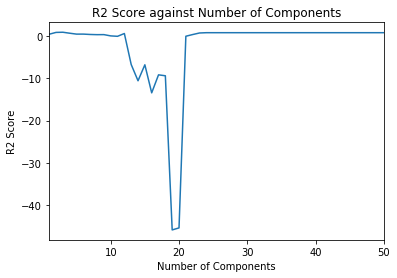

In [50]:
df_result['R2'].plot(kind = 'line')

plt.title('R2 Score against Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('R2 Score')
plt.show()

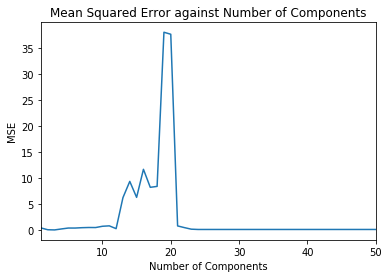

In [51]:
df_result['MSE'].plot(kind = 'line')

plt.title('Mean Squared Error against Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('MSE')
plt.show()

In [59]:
r2_max = df_result['R2'].max()
r2_max_n = df_result['R2'].idxmax()

mse_min = df_result['MSE'].min()
mse_min_n = df_result['MSE'].idxmin()
print('Best n:', r2_max_n, 'R2 score:', r2_max)
print('Best n:', mse_min_n, 'MSE:', mse_min)

Best n: 3 R2 score: 0.8899763611070806
Best n: 3 MSE: 0.08916902404610845


In [63]:
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:r2_max_n], y, test_size = 0.2, random_state = 1)
lr.fit(X_train, y_train)

yhat = lr.predict(X_test)

In [65]:
r2 = r2_score(y_test, yhat)
r2

0.8899763611070806

In [66]:
mse = mean_squared_error(y_test, yhat)
mse

0.08916902404610845

In [67]:
eigenvectors = pca.components_
pcr_coefs = eigenvectors[:r2_max_n, :].T @ lr.coef_

pcr_coefs.shape

(234,)

In [69]:
# Venues categories with the most positive effect: 

X.columns[np.argsort(-pcr_coefs)[:10]].values

array(['Dessert Shop', 'Performing Arts Venue', 'Yoga Studio',
       'Cocktail Bar', 'Bakery', 'Hotel', 'Sporting Goods Shop', 'Lounge',
       'Dumpling Restaurant', 'Ramen Restaurant'], dtype=object)

In [70]:
# Venues categories with the most negative effect: 

X.columns[np.argsort(pcr_coefs)[:10]].values

array(['Fast Food Restaurant', 'Sandwich Place', 'Steakhouse',
       'Sushi Restaurant', 'Supermarket', 'Bus Station', 'Shopping Mall',
       'High School', 'American Restaurant', 'Trail'], dtype=object)

In [71]:
# Venue categories with the least effect:
X.columns[np.argsort(abs(pcr_coefs))[:10]].values

array(['Military Base', 'Video Store', 'Rest Area', 'Beer Store',
       'Basketball Court', 'Bubble Tea Shop', 'Pet Store',
       'College Cafeteria', 'Soccer Field', 'Chinese Breakfast Place'],
      dtype=object)

**Comments:**   
Despite better r2 score for the principal component analysis, the results obtained are still not very conclusive as it doesn't quite tally with our daily common sense. However, there are some insights to be gained. We can see that while the venue categories that have the most negative impact are actually amenities that should in no way lower real estate prices, we can also observe that these categories are more likely to be found in the heartlands. As compared to the venue categories with the most positive impact, the categories there are places more likely to be found in town. As such, we can conclude that the type of amenities around a real estate is unlikely to be a factor affecting its rental price. But rather, the rental price is more dependent on the location itself - i.e., prices are higher in town centres, whether or not they have useful amenities around or not. 